In [1]:
import math

import numpy

import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0-dev20191009


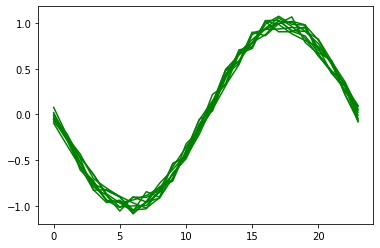

In [2]:
xrange = tf.linspace(-math.pi, math.pi, 24)
baseline_data = tf.math.sin(xrange)

def get_data():
    return tf.map_fn(lambda e: e + numpy.random.uniform(-0.1, 0.1), baseline_data)

for i in range(10):
    plt.plot(get_data(), color="green")

plt.show()

In [3]:
def build_model():
    model = keras.Sequential([
        layers.Dense(32, activation='relu', input_shape=[24]),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(24)
    ])
    
    optimizer = tf.optimizers.Adam(learning_rate=0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [4]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                800       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                792       
Total params: 2,664
Trainable params: 2,664
Non-trainable params: 0
_________________________________________________________________


In [5]:
DATA_AMOUNT = 5000

In [6]:
input_data = numpy.zeros(shape=(DATA_AMOUNT, 24))
print(input_data[:2])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [7]:
for i in range(DATA_AMOUNT):
    input_data[i] = get_data()
    
input_data.shape
print(input_data[:2])

[[ 8.44087219e-04 -3.66415411e-01 -5.86339951e-01 -6.72835231e-01
  -9.03928280e-01 -1.04322207e+00 -9.74829137e-01 -9.64686155e-01
  -7.44236827e-01 -6.93248391e-01 -4.66274351e-01 -2.34265372e-01
   2.22866505e-01  4.01759654e-01  5.45640469e-01  7.24855721e-01
   9.09031987e-01  8.98090899e-01  1.01267397e+00  9.82692242e-01
   7.50307083e-01  5.70490658e-01  3.23751777e-01  4.67055403e-02]
 [ 1.09626744e-02 -3.61979753e-01 -4.94806558e-01 -6.65023446e-01
  -7.88968265e-01 -1.02645004e+00 -1.00434422e+00 -1.02469492e+00
  -7.92912781e-01 -5.35050511e-01 -3.08620363e-01 -1.74407601e-01
   1.06742375e-01  3.03900272e-01  7.26072133e-01  8.80198836e-01
   9.20957267e-01  1.02827036e+00  9.41765130e-01  8.67855608e-01
   6.87357426e-01  5.14315426e-01  3.47008049e-01  6.25837296e-02]]


In [8]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 20

history = model.fit(
  input_data, input_data,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................

In [9]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
15,0.003041,0.046880,0.003041,0.003019,0.046704,0.003019,15
16,0.003012,0.046628,0.003012,0.003027,0.046649,0.003027,16
17,0.002991,0.046399,0.002991,0.002966,0.046228,0.002966,17
18,0.002962,0.046107,0.002962,0.002948,0.046027,0.002948,18
19,0.002941,0.045892,0.002941,0.002942,0.045918,0.002942,19


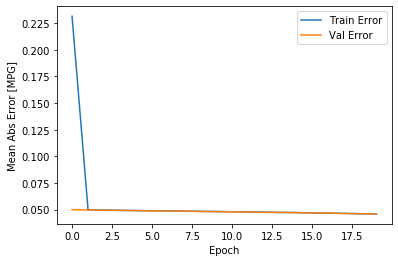

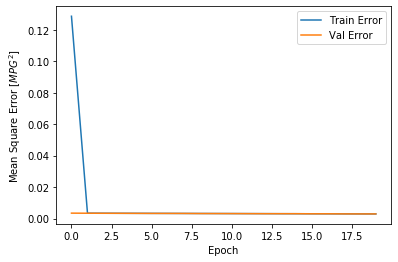

In [10]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [14]:
test_data = [[-0.02933731, -0.32642642, -0.60788834, -0.72397864, -0.97547996, -0.9415378,
  -1.0159543,  -0.91429764, -0.89873546, -0.7082084,  -0.34106407, -0.09575787,
   0.18419927,  0.33925903,  0.54406685,  0.87100095,  0.87787116,  0.9199926,
   1.055753,    0.8475192,   0.747532,    0.47048718,  0.26311573, -0.06118441]]

test_prediction = model.predict(test_data)

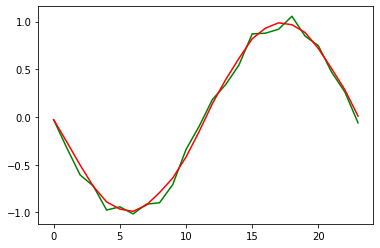

In [16]:
plt.plot(test_data[0], color="green")
plt.plot(test_prediction[0], color="red")

plt.show()

In [17]:
mse = tf.keras.losses.MeanSquaredError()
loss = mse(test_data[0], test_prediction[0])
print('Loss: ', loss.numpy())

Loss:  0.0035400502


In [18]:
anormal_data = [[-0.12414624, -0.29343495, -0.55113226, -0.70649445, -0.91841286, -0.9783308,
  -2.0023081,  -0.9287611,  -0.8214135,  -0.582845,   -0.391986,   -0.10014512,
   0.10427438,  0.41322625,  0.23685083,  0.8368965,   0.9379528,   0.2655445,
   1.0262748,   0.8895786,   0.2657625,   0.54400456,  0.48883213, -0.06084715]]

anormal_prediction = model.predict(anormal_data)

In [19]:
loss = mse(anormal_data[0], anormal_prediction[0])
print('Loss: ', loss.numpy())

Loss:  0.075837344


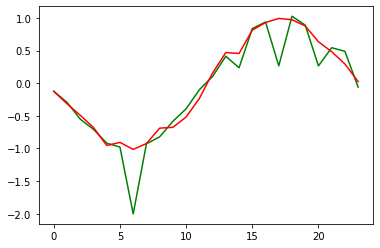

In [20]:
plt.plot(anormal_data[0], color="green")
plt.plot(anormal_prediction[0], color="red")

plt.show()